# Computer Vision 3: Image segmentation

* What is image segmentation?
* Different kinds of segmentation applications
* The U-net model architecture
* Applying U-nets to segmentation problems

In [ ]:
# Library om YouTube videos te importeren 

from IPython.display import YouTubeVideo, Image

## 1 What is image segmentation?

### 1.1 Definition

OIn an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

![Computer vision applications](cold.jpeg)

### 1.2 Different kinds of segmentation applications

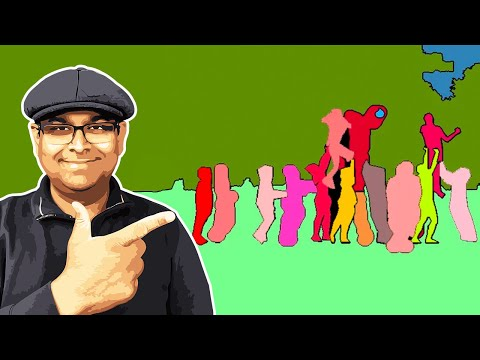

In [ ]:
YouTubeVideo("5QUmlXBb0MY", width=800, height=500)

There are several types of image segmentation algorithms, which can be broadly classified into the following categories:

1. Threshold-based segmentation: These algorithms use a predefined threshold value to separate pixels into different groups based on their intensity. Examples include global thresholding, adaptive thresholding, and Otsu's method.

2. Region-based segmentation: These algorithms focus on finding connected regions with similar properties, such as color or texture. Examples include region growing, split and merge, and watershed algorithms.

3. Edge-based segmentation: These algorithms identify boundaries or edges between different regions by detecting abrupt changes in pixel values. Examples include the Canny edge detector, Sobel operator, and Laplacian of Gaussian (LoG) methods.

4. Clustering-based segmentation: These algorithms group pixels with similar characteristics using unsupervised clustering techniques, such as K-means, Fuzzy C-means, and Mean Shift.

5. Deep learning-based segmentation: These algorithms utilize deep learning models, such as convolutional neural networks (CNNs), to perform image segmentation. Some popular deep learning-based segmentation methods include:

* Fully Convolutional Networks (FCNs): These networks consist of convolutional layers and are designed to process images of different sizes. They can output a segmentation map of the same size as the input image.

* U-Net: A specific type of CNN, U-Net has an encoder-decoder architecture with "skip connections" that allow it to effectively learn and capture contextual information at different scales. It's widely used in biomedical image segmentation.

* DeepLab: DeepLab is another CNN-based approach that combines atrous (dilated) convolutions, spatial pyramid pooling, and conditional random fields (CRFs) to improve segmentation accuracy.

* Mask R-CNN: This method extends the Faster R-CNN object detection framework by adding a branch for predicting segmentation masks on each Region of Interest (ROI). It's effective for instance segmentation, where the goal is to identify and distinguish between multiple instances of objects in an image.

### 1.3 The U-net architecture of neural networks

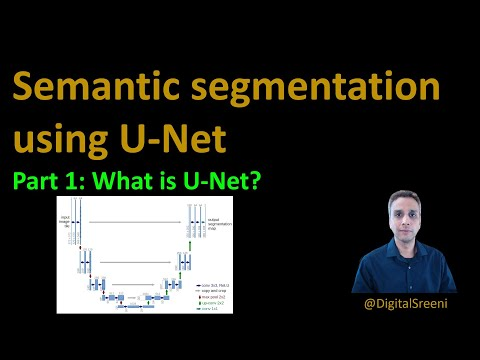

In [ ]:
YouTubeVideo("azM57JuQpQI", width=800, height=500)    

There are two important concepts to know about in U-nets. They are **upsampling** and **skip-connections**.

**Upsampling:** U-net needs to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution. This is done using an upsampling layer. There are different kinds of upsampling algorithms that can be used in this case. We will use something called a "2-D transposed convolution".

**Skip connections:** Skip connections, also known as shortcut connections, are a key component of the U-Net architecture. U-Net has an encoder-decoder structure, where the encoder successively downsamples the input image to capture higher-level features, and the decoder upsamples the feature maps to generate a segmentation map of the same size as the input image.

Skip connections are used to connect the corresponding layers in the encoder and decoder parts of the network. They enable the direct transfer of feature maps from the encoder to the decoder, essentially "skipping" intermediate layers. This is done by concatenating or adding feature maps from the encoder to the upsampled feature maps in the decoder.

Skip connections serve two main purposes:

1. Recovering spatial information: The downsampling process in the encoder leads to a loss of spatial information, which is crucial for accurate segmentation. By combining low-level spatial features from the encoder with high-level semantic features from the decoder, skip connections help in reconstructing the fine-grained details in the segmentation output.

2. Easing the gradient flow: Deep neural networks often suffer from vanishing gradient problems, where gradients diminish as the network gets deeper. Skip connections help alleviate this issue by skipping layers, and thus propagating gradients directly back a few layers.

## 2 Coding an image segmentation model with TensorFlow & Keras

In this section, we will look at two coding examples where we will apply some of the theory from the previous sections.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) [(Parkhi et al, 2012)](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

Class 1: Pixel belonging to the pet.
Class 2: Pixel bordering the pet.
Class 3: None of the above/a surrounding pixel. 

This tutorial is ispired by this [blog post](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/) by [pyimagesearch](https://pyimagesearch.com/) and this [tutorial](https://www.tensorflow.org/tutorials/images/segmentation) on the official TensorFlow website.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import PIL
from PIL import Image
from PIL import ImageOps

import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Only run on Google Colab
from google.colab.patches import cv2_imshow

### 2.1 Getting the dataset

We will use the built-in pets dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets). Check out the catalog to see all the available datasets there.

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2DJWSR/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2DJWSR/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### 2.1 Pre-processing the images

We will make sure that the image color values are normalized to the [0, 1] range. We will resize the images as well as their masks to be 128 x 128 pixels. As mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'],
                                 (128, 128),
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                                )

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### 2.2 Adding image augmentation

We add image augmentation by randomly-flipping an image. Since we need to augment both the image and its mask, we need to create a new class that can do this, by extending the Keras base layer class, and applying the augmentation to both the images and labels.

In [12]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=43)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

### 2.3 Building the preprocessing + augmentation pipeline

Putting together the preprocessing of the images and the random-flip augmentation.

The "train" and "test" splits are built in the dataset. Let us get this data.

In [13]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Build the inut pipeline.

In [14]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

The following code will visualize an image and its corresponding mask from the dataset.

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

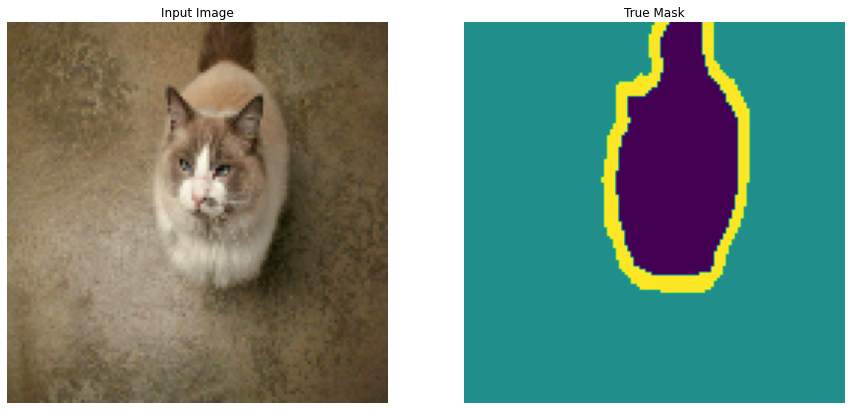

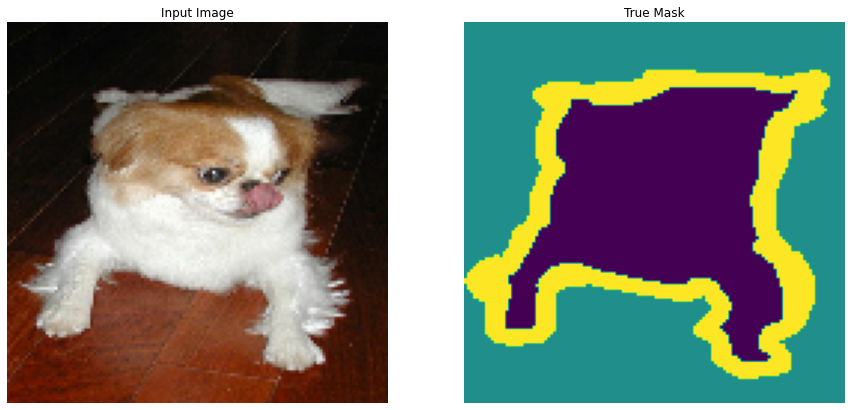

In [16]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

### 2.4 Building a U-net model

The U-net model is quite large. Therefore, to simplify our task of building the model, we will code some **helper functions**. The U-net model also has skip connections between the encoder and decoder, so we will need to concatenate some layers. The **Keras Functional API** is most appropriate for this purpose.

In [17]:
# Helper functions to construct specific blocks of the model

def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

The [Conv2DTranspose layer](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/), also called a "deconvolution layer", is what is responsible for upscaling the extracted features back to the shape of the input. These layers are responsible for building the right half of the "U" in "U-net".

In [18]:
# Build the U-net model

def build_unet_model(output_channels:int):

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(output_channels, 1, padding="same")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

Let's see what our model architecture looks like.

In [19]:
OUTPUT_CLASSES = 3

unet_model = build_unet_model(output_channels=OUTPUT_CLASSES)

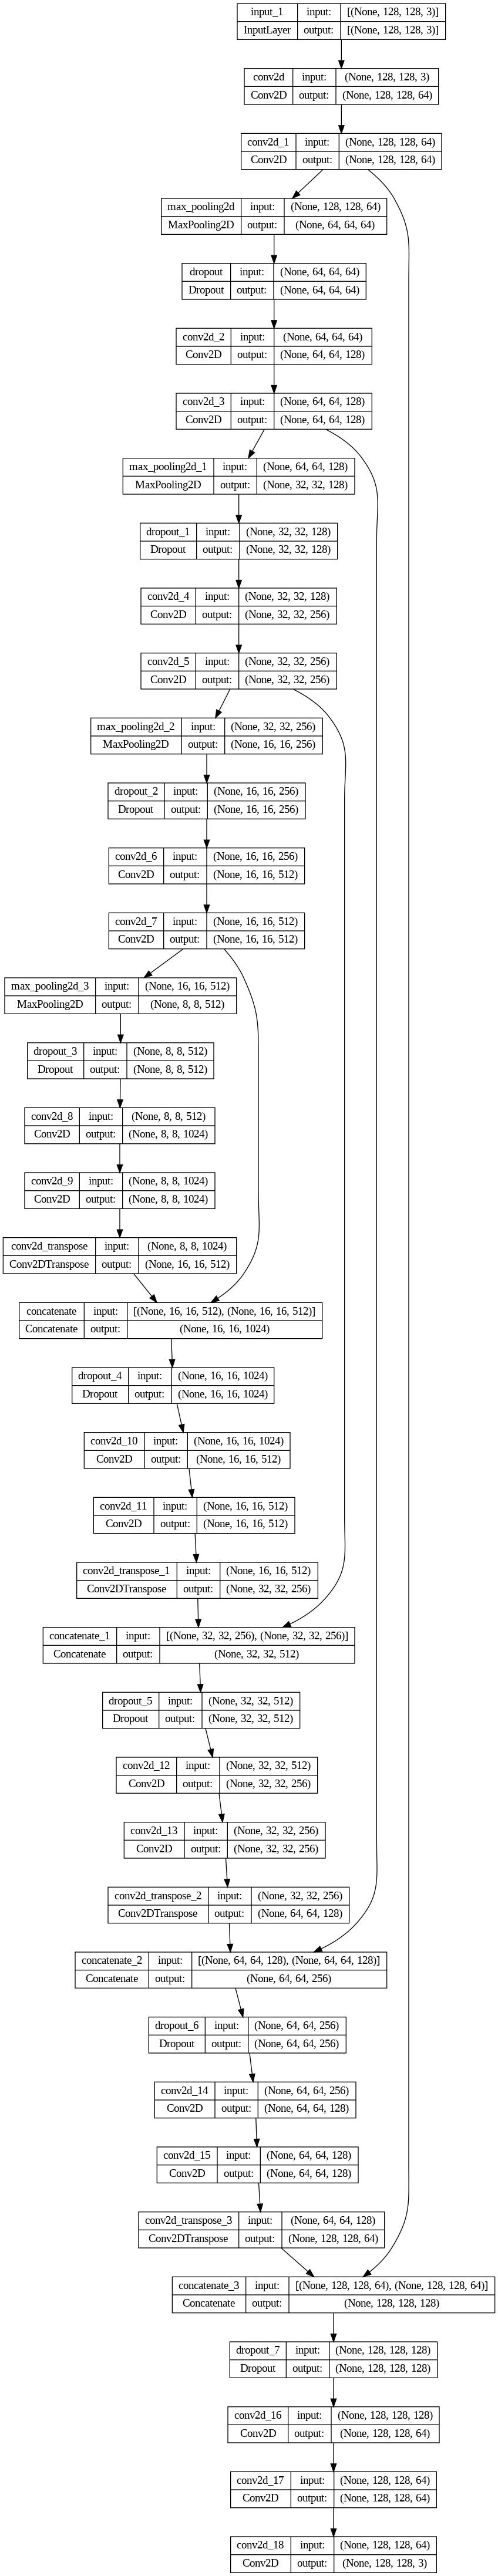

In [20]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

### 2.5 Compile the model

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [21]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2.6 Train the model

Try out the model first to check what it predicts before training:

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


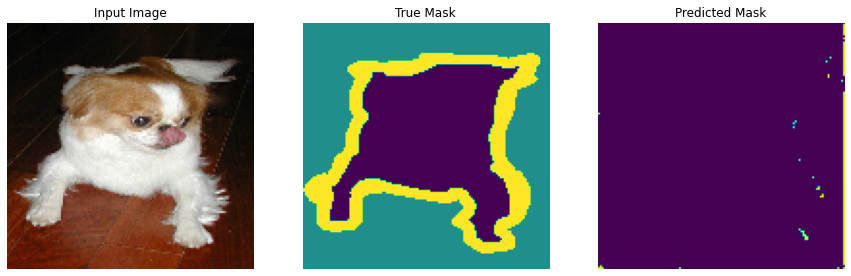

In [23]:
show_predictions()

Now train the model.

In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

history = unet_model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
115/115 [==============================] - 83s 527ms/step - loss: 0.9051 - accuracy: 0.5985 - val_loss: 0.7521 - val_accuracy: 0.6673
Epoch 2/20
115/115 [==============================] - 62s 540ms/step - loss: 0.7162 - accuracy: 0.6896 - val_loss: 0.6680 - val_accuracy: 0.7214
Epoch 3/20
115/115 [==============================] - 62s 541ms/step - loss: 0.6211 - accuracy: 0.7486 - val_loss: 0.6541 - val_accuracy: 0.7457
Epoch 4/20
115/115 [==============================] - 60s 521ms/step - loss: 0.5561 - accuracy: 0.7811 - val_loss: 0.5306 - val_accuracy: 0.7938
Epoch 5/20
115/115 [==============================] - 60s 520ms/step - loss: 0.5002 - accuracy: 0.8054 - val_loss: 0.4762 - val_accuracy: 0.8132
Epoch 6/20
115/115 [==============================] - 60s 520ms/step - loss: 0.4722 - accuracy: 0.8163 - val_loss: 0.4462 - val_accuracy: 0.8293
Epoch 7/20
115/115 [==============================] - 60s 521ms/step - loss: 0.4358 - accuracy: 0.8316 - val_loss: 0.3992 - val_ac

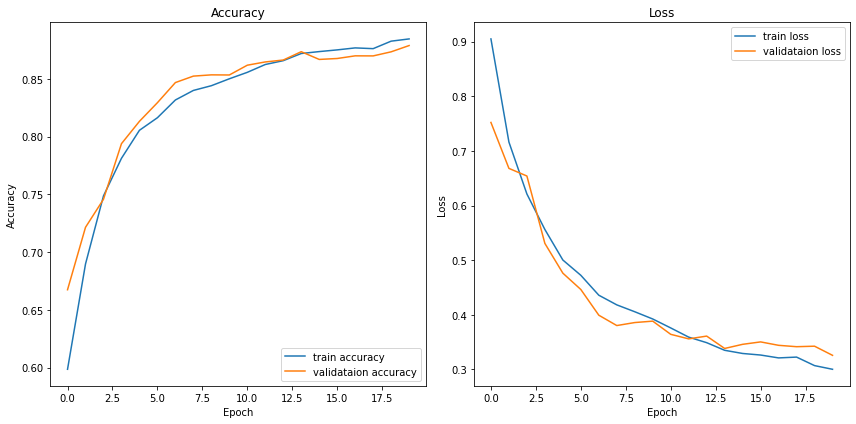

In [25]:
# Plot loss curves

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="train accuracy")
plt.plot(epochs_range, val_acc, label="validataion accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="train loss")
plt.plot(epochs_range, val_loss, label="validataion loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

fig.tight_layout()
plt.show()

### 2.7 Visualize the results

Let's visualize some of the results on the test images.

1/1 [==============================] - 0s 35ms/step


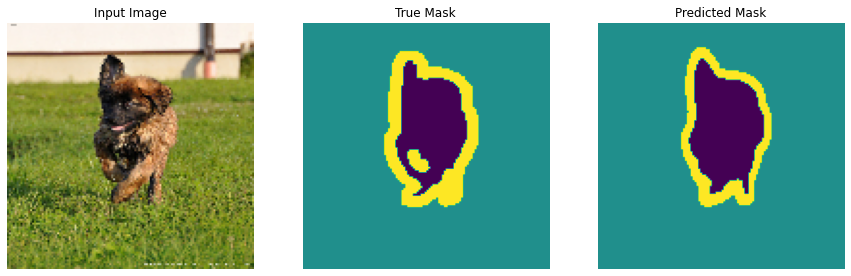

1/1 [==============================] - 0s 44ms/step


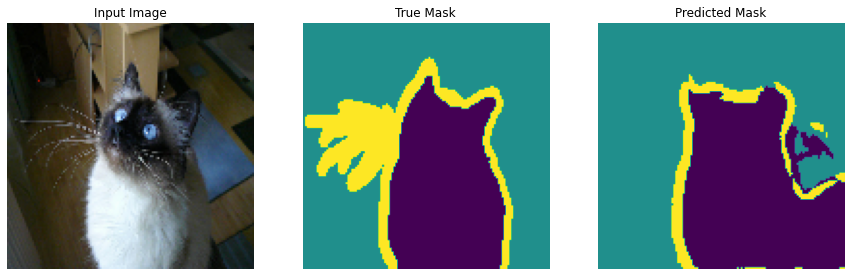

1/1 [==============================] - 0s 25ms/step


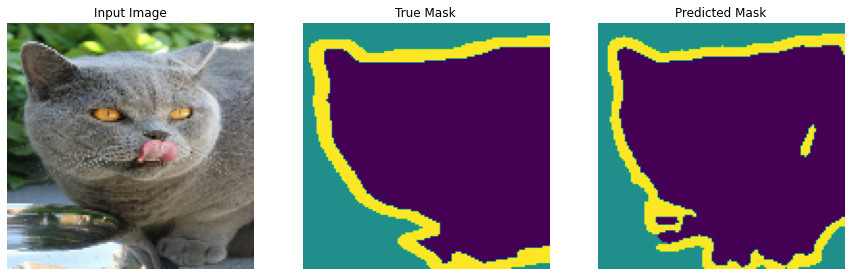

In [26]:
show_predictions(test_batches, 3)